# Project 3: Retinal Vessel Extraction — Sauvola vs Niblack

**Task:** Extract thin vessels in fundus images  
**Methods:** Niblack vs Sauvola thresholding  
**Dataset:** Kaggle — DRIVE retinal dataset mirrors  
**Compare:** Sensitivity for thin vessels  
**Learning:** Local threshold behavior on thin structures

---

### Step 1: Install Dependencies
Ensure you have the Kaggle API and image processing libraries installed.

In [19]:
!pip install kaggle opencv-python scikit-image matplotlib scikit-learn numpy

### Step 2: Download Dataset via Kaggle API
**Important:** You need your `kaggle.json` API token. If you are using Google Colab, upload it to the root directory. If running locally, place it in `~/.kaggle/`.

In [ ]:
import os
import zipfile

# Setup Kaggle directory and permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 2>/dev/null || echo "Make sure kaggle.json is in your working directory!"
!chmod 600 ~/.kaggle/kaggle.json 2>/dev/null

# Download a standard DRIVE dataset mirror from Kaggle
!kaggle datasets download -d abdallahwagih/retina-blood-vessel

# Extract the dataset
dataset_zip = 'retina-blood-vessel.zip'
if os.path.exists(dataset_zip):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall('DRIVE_dataset')
    print("Dataset successfully extracted.")
else:
    print("Dataset zip not found. Check your Kaggle API configuration.")

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
retina-blood-vessel.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset successfully extracted.


### Step 3: Import Libraries and Define Metrics

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix
import glob

def calculate_sensitivity(y_true, y_pred):
    """
    Calculates Sensitivity (True Positive Rate) = TP / (TP + FN)
    Measures the proportion of actual vessels correctly identified.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # labels=[0, 1] ensures the matrix is 2x2 even if a class is missing
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1]).ravel()

    return tp / (tp + fn) if (tp + fn) > 0 else 0

### Step 4: Load Data and Preprocess
We extract the green channel because hemoglobin absorbs green light, providing the highest contrast for blood vessels.

In [22]:
# Locate images in the extracted folder (paths may vary slightly by mirror)
image_files = sorted(glob.glob('DRIVE_dataset/**/image/*.png', recursive=True))
mask_files = sorted(glob.glob('DRIVE_dataset/**/mask/*.png', recursive=True))

if not image_files:
    print("Error: Could not find images. Inspect the 'DRIVE_dataset' folder and adjust the glob path.")
else:
    # Load the first image and its ground truth mask
    img_path = image_files[0]
    mask_path = mask_files[0]

    original_img = cv2.imread(img_path)
    ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure ground truth is strictly binary (0 and 1)
    ground_truth_binary = (ground_truth > 127).astype(np.uint8)

    # Preprocessing: Extract Green Channel
    b, g, r = cv2.split(original_img)

    # Preprocessing: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_g = clahe.apply(g)

    # Preprocessing: Invert image (Algorithms look for bright objects; vessels are dark)
    inverted_img = cv2.bitwise_not(enhanced_g)

### Step 5: Apply Niblack and Sauvola Algorithms

In [23]:
if image_files:
    # Define the local neighborhood size (must be an odd number)
    window_size = 25

    # 1. Niblack Thresholding
    thresh_niblack = threshold_niblack(inverted_img, window_size=window_size, k=0.1)
    binary_niblack = (inverted_img > thresh_niblack).astype(np.uint8)

    # 2. Sauvola Thresholding
    thresh_sauvola = threshold_sauvola(inverted_img, window_size=window_size, k=0.1)
    binary_sauvola = (inverted_img > thresh_sauvola).astype(np.uint8)

    # Calculate Sensitivities
    sens_niblack = calculate_sensitivity(ground_truth_binary, binary_niblack)
    sens_sauvola = calculate_sensitivity(ground_truth_binary, binary_sauvola)

    print(f"Niblack Sensitivity: {sens_niblack:.4f}")
    print(f"Sauvola Sensitivity: {sens_sauvola:.4f}")

Niblack Sensitivity: 0.9197
Sauvola Sensitivity: 0.9583


### Step 6: Visualization
Compare the raw image, the expert's ground truth, and our two algorithmic outputs.

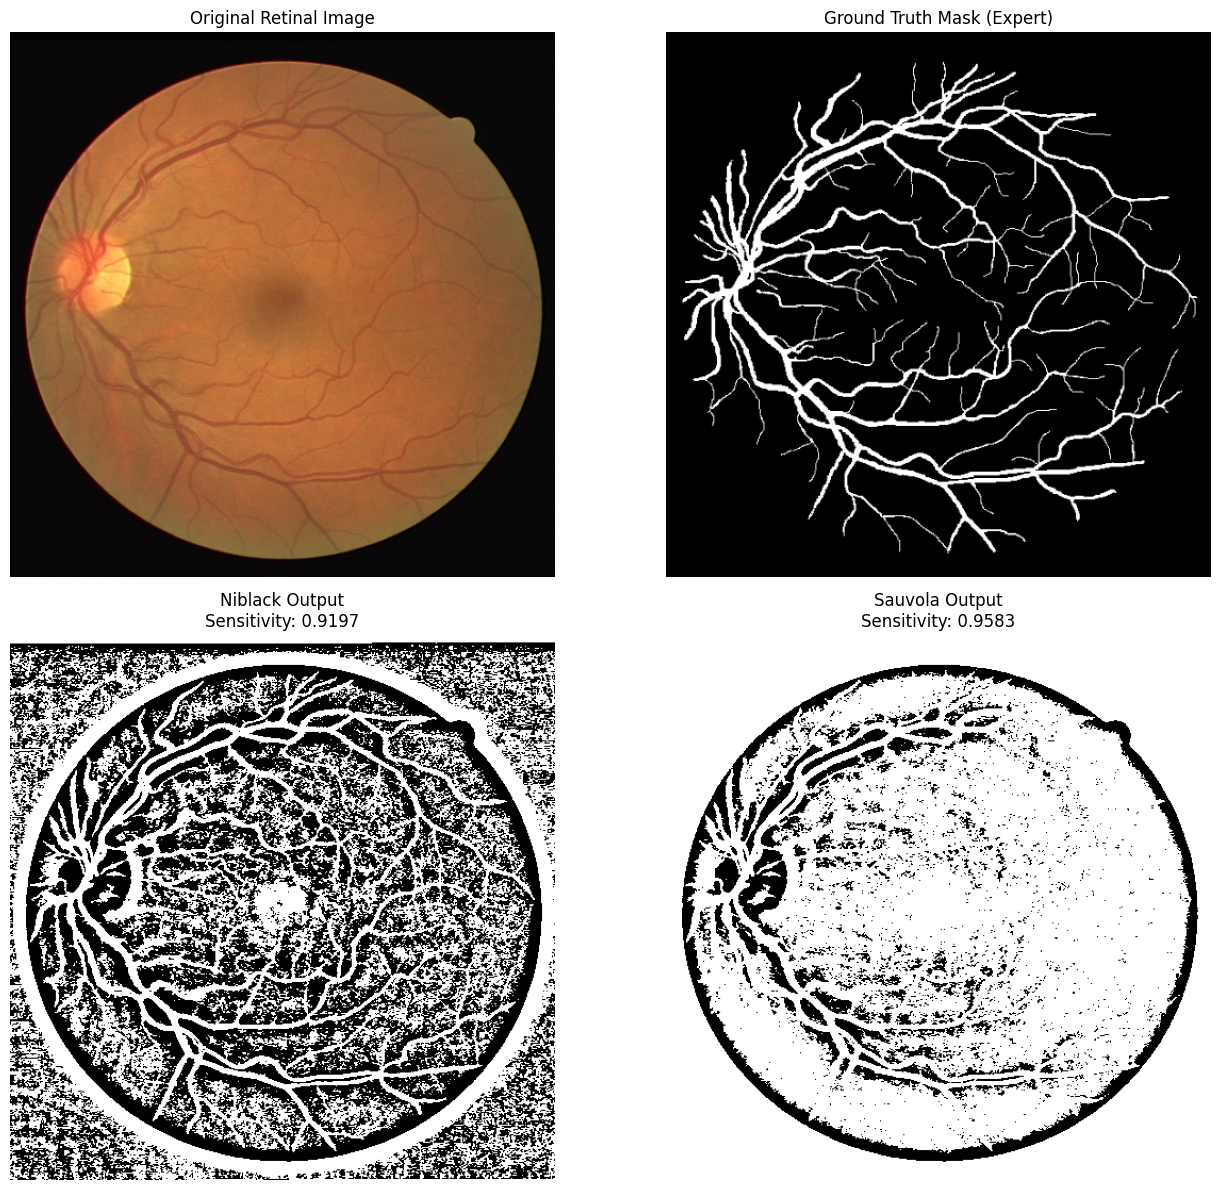

In [24]:
if image_files:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    ax = axes.ravel()

    ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Retinal Image')
    ax[0].axis('off')

    ax[1].imshow(ground_truth, cmap='gray')
    ax[1].set_title('Ground Truth Mask (Expert)')
    ax[1].axis('off')

    ax[2].imshow(binary_niblack, cmap='gray')
    ax[2].set_title(f'Niblack Output\nSensitivity: {sens_niblack:.4f}')
    ax[2].axis('off')

    ax[3].imshow(binary_sauvola, cmap='gray')
    ax[3].set_title(f'Sauvola Output\nSensitivity: {sens_sauvola:.4f}')
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()